# I - Benchmark 

# I.1 -  Design of the experiment
## 2k factorial design
The aim of this notebook is to compare the performances of Dask And Pandas using DOE methods.
At first I choosed a lot of response variables, but I decided to focus on time because this is most often what matter the most when you process big data files.
Here I choosed to apply a 2k factorial design with the following specifications : 
* k = 5
* factors are library used (pandas / dask), data_size (25M rows / 600M rows), operation (arithmetic / groupby), data_type (int/float), file_type (parquet/csv)
* Since the most time consuming tasks are the file generation (IE generating several 600M rows files), I choosed to apply a replicated full factorial design, which here corresponds to 2^5 * 32 repetitions.

A big difference with the previous version of this work is that data size is a number of rows instead of a file size, since file sizes can vary a lot depending on data stored, file format, etc.

| Factor | Name      | +          | -         |
|--------|-----------|------------|-----------|
| A      | library   | Pandas     | Dask      |
| B      | data_size | 25M rows   | 600M rows |
| C      | operation | arithmetic | groupby   |
| D      | data_type | int        | float     |
| E      | file_type | parquet    | csv       |

## Data treatement

There are high chances that the final results output contains some "NaN" results since Pandas strugle to manage datasets bigger than the RAM size.
We will therefore certainly need to adapt data processing accordingly.


# I.2 - Benchmark runs

In [1]:
import pandas as pd
import dask.dataframe as dd
import time
import os
import gc # Garbage Collector to free RAM between tests
import itertools
from utils import generate_doe_dataset

# Factor Configuration (Levels)
# UPDATED: Using Row counts as requested
FACTORS = {
    "library": ["pandas", "dask"],
    "data_size": ["25M", "600M"], # New labels for the report
    "operation": ["arithmetic", "groupby"],
    "data_type": ["int", "float"],
    "file_type": ["parquet", "csv"]
}

# MAPPING: Report Label -> Actual Filename on disk
# This allows using new labels without regenerating existing files
SIZE_TO_FILENAME = {
    "25M": "Small",
    "600M": "20GB"
}

# Number of repetitions per configuration
N_REPEATS = 3 
DATA_DIR = "benchmark_data"

In [2]:
def run_single_benchmark(library, file_path, operation, file_type):
    """
    Executes a single test and returns the execution time.
    Returns 'OOM' (Out of Memory) if memory saturates.
    """
    
    # 1. Clear RAM before starting
    gc.collect()
    
    start_time = time.time()
    
    try:
        # --- STEP A: LOADING ---
        if library == "pandas":
            if file_type == "csv":
                df = pd.read_csv(file_path)
            else: # parquet
                df = pd.read_parquet(file_path)
        
        elif library == "dask":
            if file_type == "csv":
                df = dd.read_csv(file_path)
            else: # parquet
                df = dd.read_parquet(file_path, engine="pyarrow")

        # --- STEP B: OPERATION ---
        if operation == "arithmetic":
            # Simple operation: column * 2
            # We assign the result to force computation but don't store it for long
            res = df["Speed"] * 2
        
        elif operation == "groupby":
            # Complex operation: GroupBy + Mean
            res = df.groupby("Destination")["Speed"].mean()

        # --- STEP C: EXECUTION (TRIGGER) ---
        if library == "dask":
            # For Dask, nothing is computed until .compute() is called
            _ = res.compute()
        else:
            # For Pandas, computation is eager, but we ensure the variable is accessed
            _ = res

        end_time = time.time()
        return end_time - start_time

    except MemoryError:
        return "OOM" # Out Of Memory
    except Exception as e:
        return f"ERROR: {str(e)}"

In [3]:
# Generate all possible combinations (Cartesian Product)
keys, values = zip(*FACTORS.items())
experiment_matrix = [dict(zip(keys, v)) for v in itertools.product(*values)]

results = []

print(f"Starting Benchmark: {len(experiment_matrix)} configurations to test.")
print(f"Repetitions per test: {N_REPEATS}\n")

for i, config in enumerate(experiment_matrix):
    print(f"--- Run {i+1}/{len(experiment_matrix)} : {config} ---")
    
    # 1. Data Verification / Generation
    # We use the mapping to find the actual file on disk ("Small" / "20GB")
    file_system_label = SIZE_TO_FILENAME[config['data_size']]
    
    # Reconstruct the filename expected by utils.py using the OLD label
    base_filename = f"data_{file_system_label}_{config['data_type']}"
    target_path = os.path.join(DATA_DIR, base_filename)
    
    # Add extension to check for existence
    full_path_check = target_path + ".csv" if config['file_type'] == "csv" else target_path + ".parquet"
    
    # If file doesn't exist, generate it (using the file_system_label)
    if not os.path.exists(full_path_check) and not os.path.exists(target_path):
        print(f" >> Generating missing data ({file_system_label})...")
        # IMPORTANT: We pass the old label ("Small"/"20GB") to utils because utils expects that
        generate_doe_dataset(file_system_label, config['data_type'], config['file_type'], DATA_DIR)
        
    # Define the path argument for the benchmark function
    file_path_arg = full_path_check if config['file_type'] == "csv" else target_path + ".parquet"

    # 2. Execute Repetitions
    run_times = []
    status = "Success"
    
    for r in range(N_REPEATS):
        duration = run_single_benchmark(
            config['library'], 
            file_path_arg, 
            config['operation'], 
            config['file_type']
        )
        
        if isinstance(duration, str): # Error or OOM
            status = duration
            run_times = [None]
            print(f"    Repetition {r+1}: FAILED ({duration})")
            break 
        else:
            run_times.append(duration)
            print(f"    Repetition {r+1}: {duration:.4f} s")

    # 3. Result Aggregation
    if status == "Success":
        final_time = pd.Series(run_times).median()
    else:
        final_time = None

    # 4. Save to list
    # The 'config' dict still contains "25M"/"600M", so the CSV will be correct
    result_entry = config.copy()
    result_entry['time_sec'] = final_time
    result_entry['status'] = status
    results.append(result_entry)

Starting Benchmark: 32 configurations to test.
Repetitions per test: 3

--- Run 1/32 : {'library': 'pandas', 'data_size': '25M', 'operation': 'arithmetic', 'data_type': 'int', 'file_type': 'parquet'} ---
    Repetition 1: 1.5666 s
    Repetition 2: 1.6662 s
    Repetition 3: 1.4439 s
--- Run 2/32 : {'library': 'pandas', 'data_size': '25M', 'operation': 'arithmetic', 'data_type': 'int', 'file_type': 'csv'} ---
    Repetition 1: 6.3579 s
    Repetition 2: 6.0556 s
    Repetition 3: 5.6837 s
--- Run 3/32 : {'library': 'pandas', 'data_size': '25M', 'operation': 'arithmetic', 'data_type': 'float', 'file_type': 'parquet'} ---
    Repetition 1: 1.3749 s
    Repetition 2: 1.3007 s
    Repetition 3: 1.5849 s
--- Run 4/32 : {'library': 'pandas', 'data_size': '25M', 'operation': 'arithmetic', 'data_type': 'float', 'file_type': 'csv'} ---
    Repetition 1: 8.9584 s
    Repetition 2: 9.0018 s
    Repetition 3: 8.8469 s
--- Run 5/32 : {'library': 'pandas', 'data_size': '25M', 'operation': 'groupby',


KeyboardInterrupt



    Repetition 1: 305.5598 s

In [ ]:
# Create final DataFrame
df_results = pd.DataFrame(results)

# Immediate save
df_results.to_csv("benchmark_results_final.csv", index=False)

print("\n--- BENCHMARK FINISHED ---")
print("Results preview:")
display(df_results.head())

# Quick display of failures
failures = df_results[df_results['status'] != 'Success']
if not failures.empty:
    print("\nWarning, configurations that failed:")
    display(failures[['library', 'data_size', 'status']])

# II - Results Analysis


## Prepairing data 
As I explained earlier, there are 8 OOM errors by Pandas
We will split the analysis in the follwing steps : 
* *Prepairing Data:*
  * Handling OOM errors (separating all configurations where Pandas failed)
  * Using a log transformation on the time response variable (mainly to keep a constant variance)
* *Compairing Pandas vs Dask*
  * Using ANOVA as an initial full model
  * We can then use saphiro-wilk to test residue normality
  * Residuals vs Fitted plot to check the rightfullness of the previously constructed model
  * using backward elimination to try to refine the model while keeping all significative interractions
* *Analysing the scalability of Dask*
  * Creating a model using only Dask data
  * Analysing the interaction Data type X File type
  * Checking how the time scales with file sizes and types

## Prepairing Data

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv("benchmark_results_final.csv")

# 2. Handling OOM cases
df_success = df[df['status'] == 'Success'].copy()
df_oom = df[df['status'] == 'OOM'].copy()

print(f"Total Runs: {len(df)}")
print(f"Success: {len(df_success)}")
print(f"OOM (Out Of Memory): {len(df_oom)}")

# 3. Log transformation
df_success['log_time'] = np.log(df_success['time_sec'])

# 4. Creating subsets for analysis
# For Dask vs Pandas comparison
df_small = df_success[df_success['data_size'] == 'Small'].copy()

# For Dask scaling analysis
df_dask = df_success[df_success['library'] == 'dask'].copy()


Total Runs: 32
Success: 24
OOM (Out Of Memory): 8


## Pandas VS Dask comparison (Only on small data)

                              sum_sq   df           F    PR(>F)
C(file_type)               13.226858  1.0  635.911500  0.000002
C(library)                  4.986764  1.0  239.750075  0.000020
C(operation)                1.010825  1.0   48.597749  0.000934
C(library):C(file_type)     0.448943  1.0   21.583953  0.005603
C(data_type)                0.240701  1.0   11.572256  0.019213
C(operation):C(file_type)   0.149072  1.0    7.166972  0.043972
C(library):C(operation)     0.080933  1.0    3.891039  0.105576
C(file_type):C(data_type)   0.037600  1.0    1.807682  0.236558
C(library):C(data_type)     0.020107  1.0    0.966690  0.370659
C(operation):C(data_type)   0.014820  1.0    0.712517  0.437121
Residual                    0.103999  5.0         NaN       NaN

Shapiro-Wilk Test p-value: 0.9796
>> Residuals are Normal (Assumption Validated)


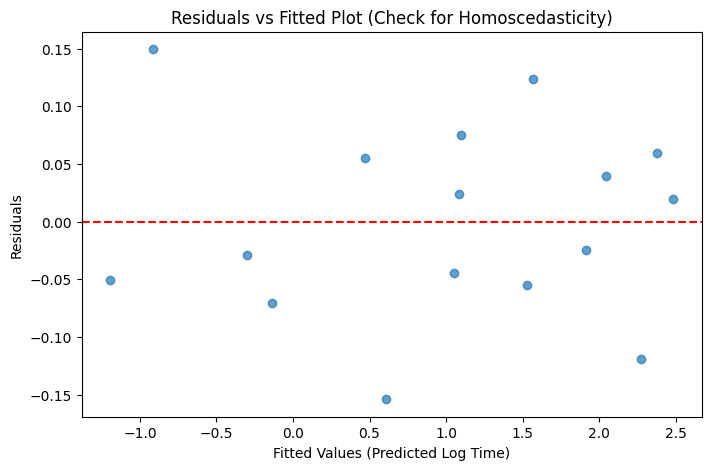

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats

# Initial Full Model: Include Main Effects and 2-way Interactions
# We use the sparsity of effects principle to ignore 3rd/4th order interactions.
model_full = ols('log_time ~ (C(library) + C(operation) + C(file_type) + C(data_type))**2', data=df_small).fit()

# Print ANOVA table (Type 2 sum of squares is standard for main effects/interactions)
anova_full = sm.stats.anova_lm(model_full, typ=2)
print(anova_full.sort_values("PR(>F)", ascending=True)) # Sorted by significance

# Shapiro-Wilk Test for Normality of Residuals
shapiro_stat, shapiro_p = stats.shapiro(model_full.resid)
print(f"\nShapiro-Wilk Test p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(">> Residuals are Normal (Assumption Validated)")
else:
    print(">> Warning: Residuals may not be Normal")

# Residuals vs Fitted Plot (Homoscedasticity Check)
plt.figure(figsize=(8, 5))
plt.scatter(model_full.fittedvalues, model_full.resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Time)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Plot (Check for Homoscedasticity)')
plt.show()

In [10]:
# Model refining (backward elimination)

# Refined Formula: (removed interactions with data type (none of them was relevant)
refined_formula = 'log_time ~ C(data_type) + C(library) + C(operation) + C(file_type) + C(library):C(file_type) + C(operation):C(file_type)'

# Alternative compact notation: 'log_time ~ C(data_type) + (C(library) + C(operation)) * C(file_type)'

model_refined = ols(refined_formula, data=df_small).fit()

print("\n--- ANOVA Table (Refined Model) ---")
#Only significant values
print(sm.stats.anova_lm(model_refined, typ=2).sort_values("PR(>F)"))

# Let's check the R-squared to see if we lost predictive power
print(f"\nAdjusted R-squared: {model_refined.rsquared_adj:.4f}")


--- ANOVA Table (Refined Model) ---
                              sum_sq   df           F        PR(>F)
C(file_type)               13.226858  1.0  462.371672  4.788016e-09
C(library)                  4.986764  1.0  174.322438  3.398698e-07
C(operation)                1.010825  1.0   35.335455  2.168427e-04
C(library):C(file_type)     0.448943  1.0   15.693707  3.296638e-03
C(data_type)                0.240701  1.0    8.414195  1.757467e-02
C(operation):C(file_type)   0.149072  1.0    5.211110  4.834176e-02
Residual                    0.257459  9.0         NaN           NaN

Adjusted R-squared: 0.9789


In [17]:
print("\n--- CONCLUSION ---")

# 1. Log mean
# Mean(Log(X)) = Log(GeometricMean(X))
mean_log_time = df_small.groupby('library')['log_time'].mean()

# 2. Geo mean 
geo_means = np.exp(mean_log_time)

print("Geo mean :")
display(geo_means.round(4))

# 3. Global speedup
speedup_geo = geo_means['pandas'] / geo_means['dask']

print(f"\n>>> CONCLUSION :")
print(f"Dask is {speedup_geo:.2f} times faster than Pandas on small data volumes")


--- CONCLUSION ---
Geo mean :


library
dask      1.5512
pandas    4.7377
Name: log_time, dtype: float64


>>> CONCLUSION :
Dask is 3.05 times faster than Pandas on small data volumes


# Scalability

                              sum_sq   df           F        PR(>F)
C(data_size)               54.068667  1.0  248.531321  7.318799e-08
C(file_type)               15.432557  1.0   70.937086  1.464013e-05
C(data_size):C(operation)   2.471237  1.0   11.359254  8.252407e-03
C(file_type):C(operation)   0.446517  1.0    2.052452  1.857663e-01
C(data_size):C(file_type)   0.143245  1.0    0.658439  4.380443e-01


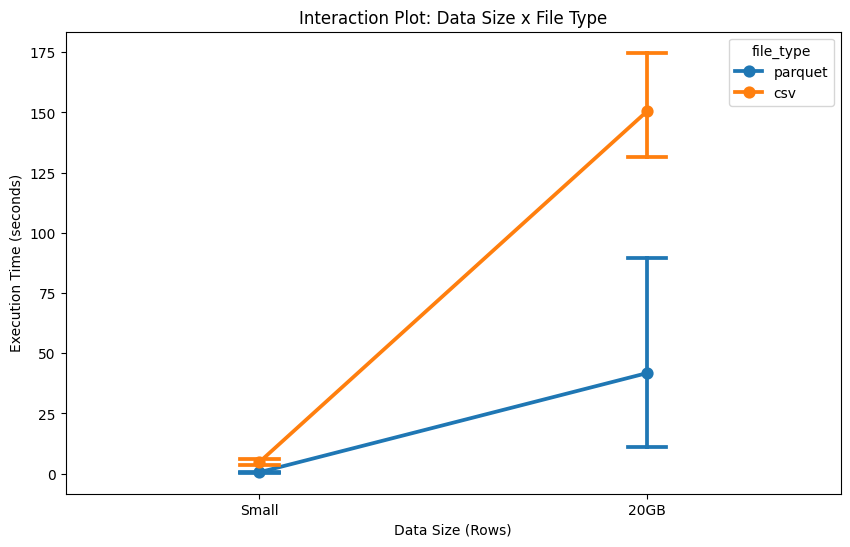

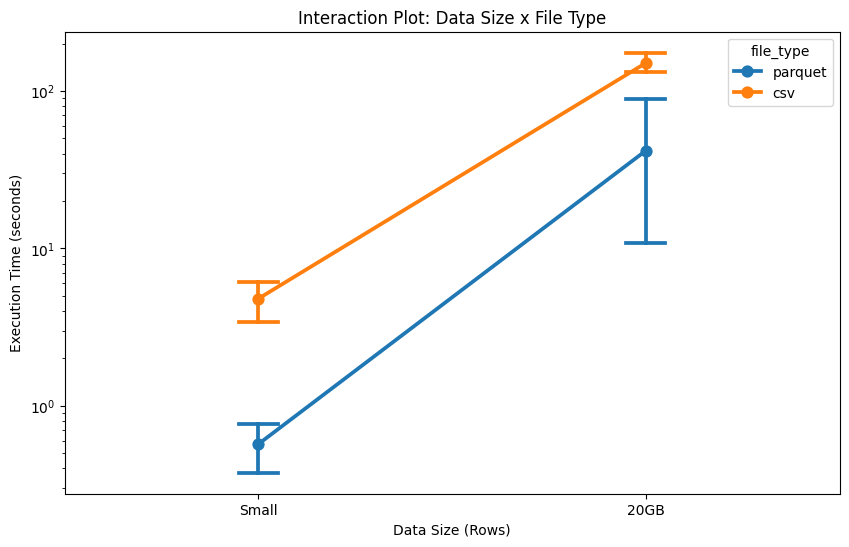


Mean Execution Time (seconds):
file_type         csv    parquet
data_size                       
20GB       150.456042  41.745111
Small        4.788851   0.570920


In [16]:
import seaborn as sns

# Creating model
model_dask = ols('log_time ~ (C(data_size) + C(file_type) + C(operation))**2', data=df_dask).fit()

# Check significant effects
anova_dask = sm.stats.anova_lm(model_dask, typ=2)
print(anova_dask.sort_values("F", ascending=False).head(5))

# We visualize this interaction to show the bottleneck of CSV at large scale.
plt.figure(figsize=(10, 6))
sns.pointplot(data=df_dask, x='data_size', y='time_sec', hue='file_type', capsize=.1)
plt.title('Interaction Plot: Data Size x File Type')
plt.xlabel('Data Size (Rows)')
plt.ylabel('Execution Time (seconds)')
plt.show()

#With logarithmic scale
plt.figure(figsize=(10, 6))
sns.pointplot(data=df_dask, x='data_size', y='time_sec', hue='file_type', capsize=.1)
plt.title('Interaction Plot: Data Size x File Type')
plt.xlabel('Data Size (Rows)')
plt.ylabel('Execution Time (seconds)')


plt.show()

# --- Checking Scaling Factor ---
# Calculate mean time for each size/file combination to see the raw increase
scaling_check = df_dask.groupby(['data_size', 'file_type'])['time_sec'].mean().unstack()
print("\nMean Execution Time (seconds):")
print(scaling_check)

# Calculate the ratio (Large / Small) to see if it's linear (approx x24 increase expected)
# If ratio > 24, efficiency drops. If < 24, efficiency increases (or overhead was high on small).

# Interpretation / conclusion 

The results are pretty obvious from what we can read on the prints above, but I will try to condense everything here. 
* Pandas dont scale well, since all the configurations with a big data size (600 000 000 rows) failed because of OutOfMemory errors.
* One big improvement from the previous version of this work is that we can finally prove that Dask is way faster than Pandas even for a small data size (25M rows, which is less than 1GB in all configurations) (3.5 times faster according to geometric means)
* On the previous point, I used geometric means to reduce the scale difference since all configurations with small data size doesnt have the same data scale. Instead of doing geometric means, we could also compare the mean of each configuration for pandas vs dask.
* Dask scaling seems almost linear, since 600M of rows / 25M of rows = 24, wich means that we multiplied data size by 24, and we got a geometric mean time ~31 times bigger from 25M rows to 600M rows with dask + csv, and ~73 times bigger with parquet, wich means that the scaling of dask should of the order of O(N^(1/x)).
* Even is Dask has way better results than Pandas, in the end the most impacting factor is the file type. With a F value of ~462 in our refined model, this is from far the most important factor of this benchmark.
    * In addition to 'being faster than csv', parquet has a smaller storage size.